In [1]:
import os
from openai import OpenAI
import json
import collections
import asyncio
import re

import subprocess
import sys


from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient
from dotenv import load_dotenv

from typing import Literal

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

from scipy.stats import gaussian_kde

import glob
from math import isnan

from matplotlib.patches import Rectangle

In [2]:
# main functions to import from src
from src import GGB_Statements, get_model_shortname, ring_csv_to_df, ring_to_roundrobin_df

from visualization_functions import plot_by_question, human_kde, h2

Questions already have IDs


In [3]:
# questions 
QUESTION_JSON = os.path.abspath('GGB_benchmark/OUS.json') 
Inverted_JSON = os.path.abspath('GGB_benchmark/OUSinverted.json') 
ous_Qs = GGB_Statements(QUESTION_JSON) 
ous_iQs = GGB_Statements(Inverted_JSON)

In [4]:
# def ring_csv_to_df(csv_file, Qs):
#     df = pd.read_csv(csv_file)
#     df['category'] = df['question_id'].apply(lambda x: Qs.get_question_category(str(x)))
#     json_columns = ['config_details', 'conversation_history', 'agent_responses']
#     for column in json_columns:
#         df[column] = df[column].apply(json.loads)
#     return df

# def ring_to_roundrobin_df(ring_df, Qs): 
#     # TODO: currently doesn't handle EVIL AGENTS 
#     # ring_df should be for a single run (chat_type)
#     if len(ring_df['chat_type'].unique()) != 1 :
#         print('ring_df should have exactly 1 chat_type')
#         return 
    

#     # NOTE: MAY NEED TO CHANGE THIS IF THIS CHANGES
#     # nubmer of rounds, models, and repeats assumes that all questions 
#     # have the same rounds, the same models and the same number of repeats (and all models have the same number of repeats)
#     n_rounds = ring_df['config_details'][0]['loops'] # number of rounds per round robin
#     n_models = len(ring_df['config_details'][0]['ensemble']) # number of models/agents
#     repeats = ring_df['run_index'].unique()
#     n_repeats = repeats.max() # number of repeats (same question different round robin)

#     if n_repeats == 1:
#         round_robin_responses = ring_df['agent_responses']
    
#     if n_repeats < 1:
#         print('No repeats. Aborting')
#         return

#     # Build new dataframe for round robins
#     rows = [] # list of dictionaries to go into df
#     for repeat in repeats:
#         if n_repeats > 1:
#             round_robin_df = ring_df[(ring_df['run_index'] == repeat)]
#             round_robin_responses = round_robin_df['agent_responses']
        
#         # indices into round_robin dataframe (for question and repeat)
#         q_indices = round_robin_df.index.to_list()    
        
#         for idx in q_indices:
#             q_num = round_robin_df.loc[idx]['question_num']
#             q_id = round_robin_df.loc[idx]['question_id']
            
#             for round in range(n_rounds):
#                 # get the message indices for this round
#                 message_indices = range(n_models*round + 1, n_models * (round+1)+1)
#                 # print(f'{message_indices}') # sanity check
#                 for msg_idx in message_indices:
#                     # TODO for when nrepeats > 1 : 
#                     # Add checks that the message ids and responses indices are correct 
#                     dict_idx = msg_idx-1

#                     # sanity check
#                     # print(f'{repeat}, {idx},{dict_idx}')
                    
#                     agent_name = round_robin_responses[idx][dict_idx]['agent_name']
#                     agent_model = round_robin_responses[idx][dict_idx]['agent_model']
#                     agent_answer = round_robin_responses[idx][dict_idx]['extracted_answer']
#                     agent_fullresponse = round_robin_responses[idx][dict_idx]['message_content']
#                     rows.append({
#                         'question_num' : q_num, 
#                         'question_id': q_id, # starts at 1
#                         'round': round+1, # starts at 1
#                         'message_index': msg_idx, # starts at 1
#                         'agent_name': agent_name,
#                         'agent_model':agent_model,
#                         'agent_answer_str': agent_answer,
#                         'agent_fullresponse': agent_fullresponse,
#                         'repeat_index': repeat + 1 # starts at 1
#                     })
#         del round_robin_df
#         del round_robin_responses

#     ring_rr_df = pd.DataFrame(rows)

#     # make sure are answers numeric
#     ring_rr_df['agent_answer'] = ring_rr_df['agent_answer_str'].str.extract(r'(\d+)')
#     ring_rr_df['agent_answer'] = pd.to_numeric(ring_rr_df['agent_answer'], errors='coerce')
#     # add category to dataframe
#     ring_rr_df['category'] = ring_rr_df['question_id'].apply(lambda x: Qs.get_question_category(str(x)))

#     ring_rr_df['chat_type'] = ring_df['chat_type'].iloc[0]

#     return ring_rr_df



In [5]:
ous_ring_csvs = glob.glob('results_ous_multi/**_ensemble_**_q1-9_n5.csv')

In [6]:
ring_rr_df = pd.DataFrame()

for csv_file in ous_ring_csvs:
    if 'inverted' in csv_file:
        current_Qs = ous_iQs
    else:
        current_Qs = ous_Qs
    
    df = ring_csv_to_df(csv_file, current_Qs)
    rr_df = ring_to_roundrobin_df(df, current_Qs)
    ring_rr_df = pd.concat([ring_rr_df, rr_df], ignore_index=True)

# add the ous question number:
ring_rr_df['ous_question_id'] = ring_rr_df['question_id'].apply(lambda x: x % 100)

In [15]:
ring_by_question = ring_rr_df.groupby(['chat_type', 'question_id','question_num','category', 'ous_question_id'])['agent_answer'].agg([
    ('mean', lambda x: np.nanmean(x)),
    ('std',  lambda x: np.nanstd(x, ddof=1)),
    ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
]).reset_index()

# ous_by_question.column
ring_by_category = ring_rr_df.groupby(['chat_type', 'category'])['agent_answer'].agg([
    ('mean', lambda x: np.nanmean(x)),
    ('std',  lambda x: np.nanstd(x, ddof=1)),
    ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
]).reset_index()

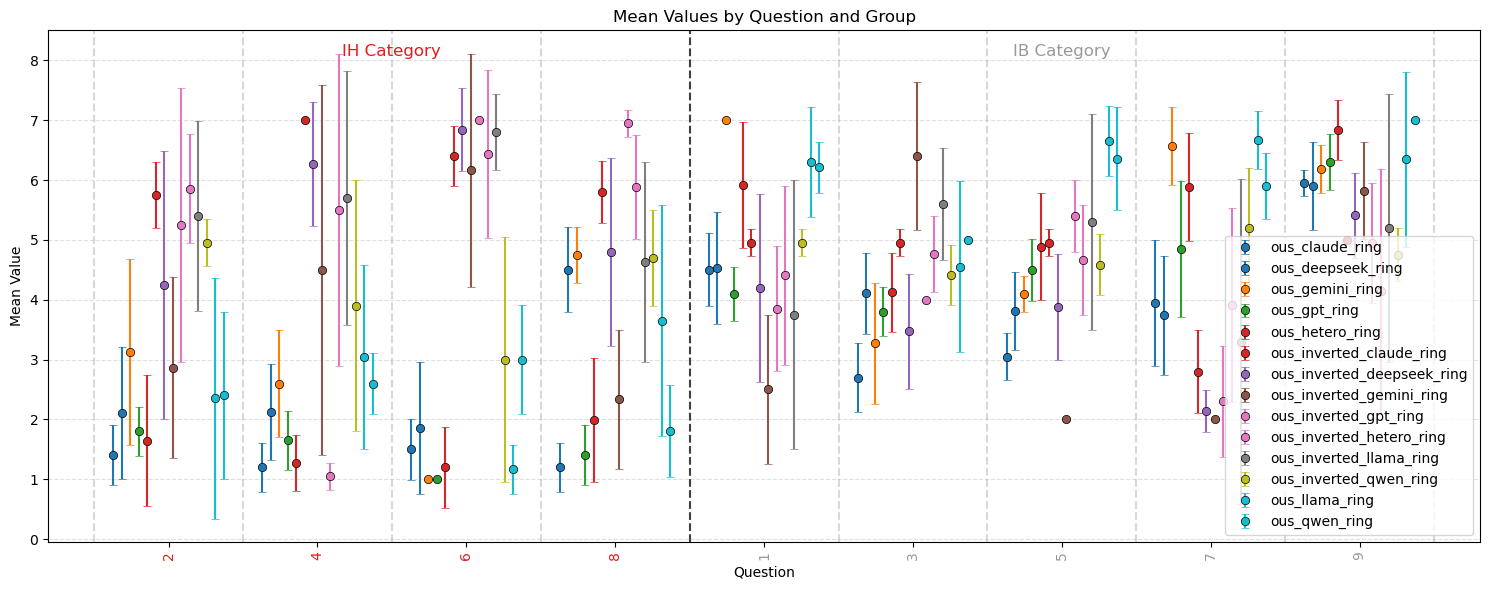

In [16]:
f = plot_by_question(data = ring_by_question, group_by = 'chat_type', category_order=['IH','IB'] )

In [ ]:
# def plot_IH_v_IB (df_by_category, use_std = True, label = 'chat_type'):
#     # Plot KDE with models on top
#     fig, ax = plt.subplots(figsize=(10, 10))

#     # Plot human KDE first using your existing function
#     human_kde(human_df=h2, ax=ax, alpha=0.7)

#     # Get unique models
#     # TODO: better color handling
#     labels = df_by_category[label].unique()
#     n = len(labels)
#     if n <=  20:
#         colors = plt.cm.tab20(np.linspace(0, 1, len(labels)))
#     else: 
#         colors = []
#         colors.extend(plt.cm.tab20(np.linspace(0, 1, 20)))
#         n -= 20
#         colors.extend(plt.cm.tab20b(np.linspace(0.25, 0.5, n)))

#     # For each model, get data for both categories and plot
#     for i, this_label in enumerate(labels):
#         # Get IH data for this model
#         ih_data = df_by_category[(df_by_category[label] == this_label) & 
#                                     (df_by_category['category'] == 'IH')]
        
#         # Get IB data for this model
#         ib_data = df_by_category[(df_by_category[label] == this_label) & 
#                                     (df_by_category['category'] == 'IB')]
        
#         # If we have both IH and IB data for this model
#         if not ih_data.empty and not ib_data.empty:
#             ih_mean = ih_data['mean'].values[0]
#             if use_std:
#                 ih_sem = ih_data['std'].values[0]
#             else: 
#                 ih_sem = ih_data['sem'].values[0]
#             ib_mean = ib_data['mean'].values[0]
#             if use_std:
#                 ib_sem = ib_data['std'].values[0]
#             else:
#                 ib_sem = ib_data['sem'].values[0]
            
#             # Plot the model point with error bars
#             ax.errorbar(
#                 ih_mean, ib_mean,
#                 xerr=ih_sem, yerr=ib_sem, 
#                 fmt='o', color=colors[i], 
#                 label=this_label, capsize=3
#             )

#     # Set axis labels and limits
#     ax.set_xlabel('IH Score')
#     ax.set_ylabel('IB Score')
#     ax.set_xlim(0, 7)
#     ax.set_ylim(0, 7)
#     ax.legend(loc='upper center',           # Anchor point of the legend 
#         bbox_to_anchor=(0.5, -0.15),  # Position relative to the axes
#         ncol=2 ,     # Number of columns (adjust based on number of groups)
#         frameon=True,                 # Show a frame around the legend
#         fontsize='medium')

#     plt.tight_layout()
#     plt.show()
#     return fig

In [26]:
def plot_IH_v_IB(df_by_category, use_std=True, label='chat_type'):
    # Plot KDE with models on top
    fig, ax = plt.subplots(figsize=(10, 10))
    # Plot human KDE first using your existing function
    human_kde(human_df=h2, ax=ax, alpha=0.7)
    
    # Get unique base configurations
    df = df_by_category.copy()
    
    # Create new columns to help with color mapping
    df['base_config'] = df[label].apply(lambda x: x.replace('ous_', '').replace('_ring', '').replace('inverted_', ''))
    df['is_inverted'] = df[label].apply(lambda x: 'inverted' in x)
    
    # Get unique base configurations
    base_configs = df['base_config'].unique()
    
    # Use a combination of colormaps for a wider range of distinct colors
    # Start with tab10, then tab20, then tab20b for even more variations
    colors_tab10 = plt.cm.tab10.colors
    colors_tab20 = plt.cm.tab20.colors
    colors_tab20b = plt.cm.tab20b.colors
    
    # Combine and get unique colors
    all_colors = []
    all_colors.extend(colors_tab10)
    
    # Add more colors if needed, but ensure they're visually distinct
    if len(base_configs) > len(all_colors):
        for color in colors_tab20:
            if color not in all_colors:
                all_colors.append(color)
    
    if len(base_configs) > len(all_colors):
        for color in colors_tab20b:
            if color not in all_colors:
                all_colors.append(color)
    
    # Create color mapping for base configurations
    base_colors = {}
    for i, config in enumerate(base_configs):
        base_colors[config] = all_colors[i % len(all_colors)]
    
    # Create a map of labels to colors
    color_map = {}
    for label_name in df[label].unique():
        # Extract base configuration
        base_config = label_name.replace('ous_', '').replace('_ring', '').replace('inverted_', '')
        # Get base color
        color_map[label_name] = base_colors[base_config]
    
    # Add color to the dataframe
    df['color'] = df[label].map(color_map)
    
    # Get unique labels
    labels = df[label].unique()
    
    # For each model, get data for both categories and plot
    for this_label in labels:
        # Get IH data for this model
        ih_data = df[(df[label] == this_label) & 
                     (df['category'] == 'IH')]
        
        # Get IB data for this model
        ib_data = df[(df[label] == this_label) & 
                     (df['category'] == 'IB')]
        
        # If we have both IH and IB data for this model
        if not ih_data.empty and not ib_data.empty:
            ih_mean = ih_data['mean'].values[0]
            if use_std:
                ih_sem = ih_data['std'].values[0]
            else: 
                ih_sem = ih_data['sem'].values[0]
            ib_mean = ib_data['mean'].values[0]
            if use_std:
                ib_sem = ib_data['std'].values[0]
            else:
                ib_sem = ib_data['sem'].values[0]
            
            # Get color from our mapping
            color = color_map[this_label]
            
            # Use the same marker outline color but different fill based on inverted status
            is_inverted = 'inverted' in this_label
            if is_inverted:
                # For inverted: outlined marker with no fill
                ax.errorbar(
                    ih_mean, ib_mean,
                    xerr=ih_sem, yerr=ib_sem, 
                    fmt='o', color=color, 
                    markerfacecolor='white',  # White fill
                    markeredgecolor=color,    # Color outline
                    markeredgewidth=1.5,      # Thicker outline
                    label=this_label, capsize=3
                )
            else:
                # For regular: filled marker
                ax.errorbar(
                    ih_mean, ib_mean,
                    xerr=ih_sem, yerr=ib_sem, 
                    fmt='o', color=color, 
                    markerfacecolor=color,    # Filled with color
                    markeredgecolor=color,
                    label=this_label, capsize=3
                )
    
    # Set axis labels and limits
    ax.set_xlabel('IH Score')
    ax.set_ylabel('IB Score')
    ax.set_xlim(1, 7)
    ax.set_ylim(1, 7)
    
    # Sort legend for better organization
    handles, labels_list = ax.get_legend_handles_labels()
    
    # Group by base configuration
    label_base_configs = [l.replace('ous_', '').replace('_ring', '').replace('inverted_', '') for l in labels_list]
    is_inverted_list = ['inverted' in l for l in labels_list]
    
    # Sort by base config first, then by inverted status (regular first, then inverted)
    sorted_indices = sorted(range(len(labels_list)), 
                           key=lambda i: (label_base_configs[i], is_inverted_list[i]))
    
    sorted_handles = [handles[i] for i in sorted_indices]
    sorted_labels = [labels_list[i] for i in sorted_indices]
    
    # Create a more compact legend with multiple columns
    n_columns = 2
    if len(sorted_labels) > 8:
        n_columns = 3  # Use 3 columns for many items
        
    ax.legend(sorted_handles, sorted_labels,
              loc='upper center',
              bbox_to_anchor=(0.5, -0.15), 
              ncol=n_columns,
              frameon=True,
              fontsize='medium')
    
    plt.tight_layout()
    plt.show()
    
    # Return both the figure and the dataframe with color information
    return fig, df

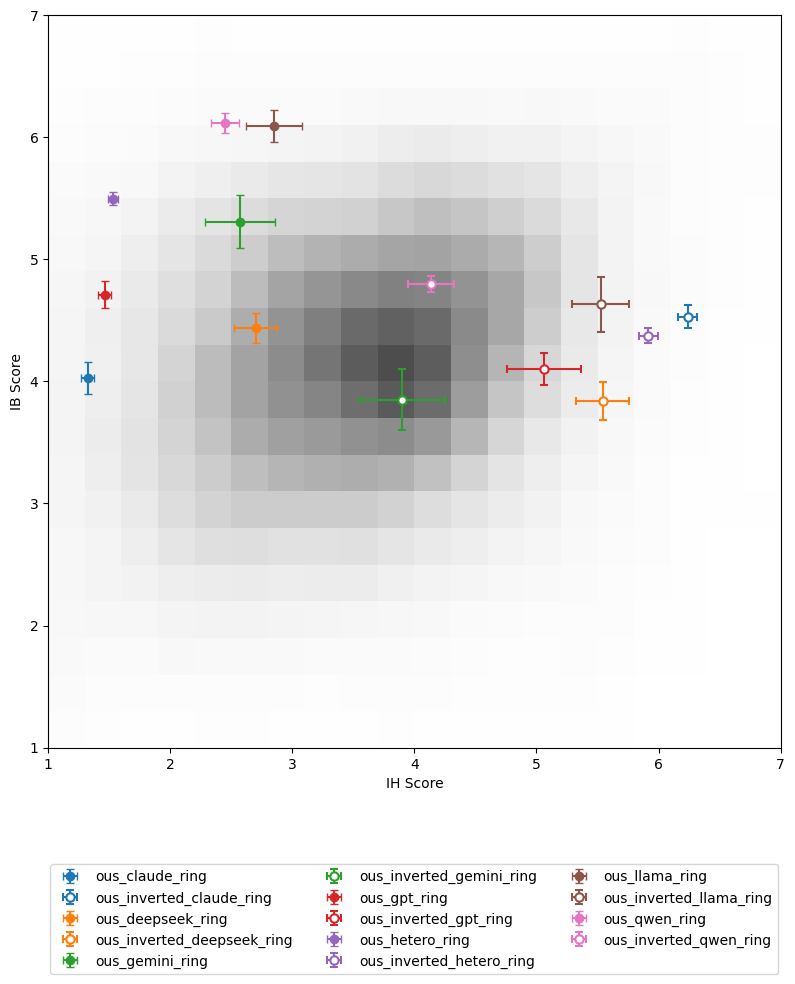

In [27]:
f = plot_IH_v_IB (ring_by_category, use_std = False)

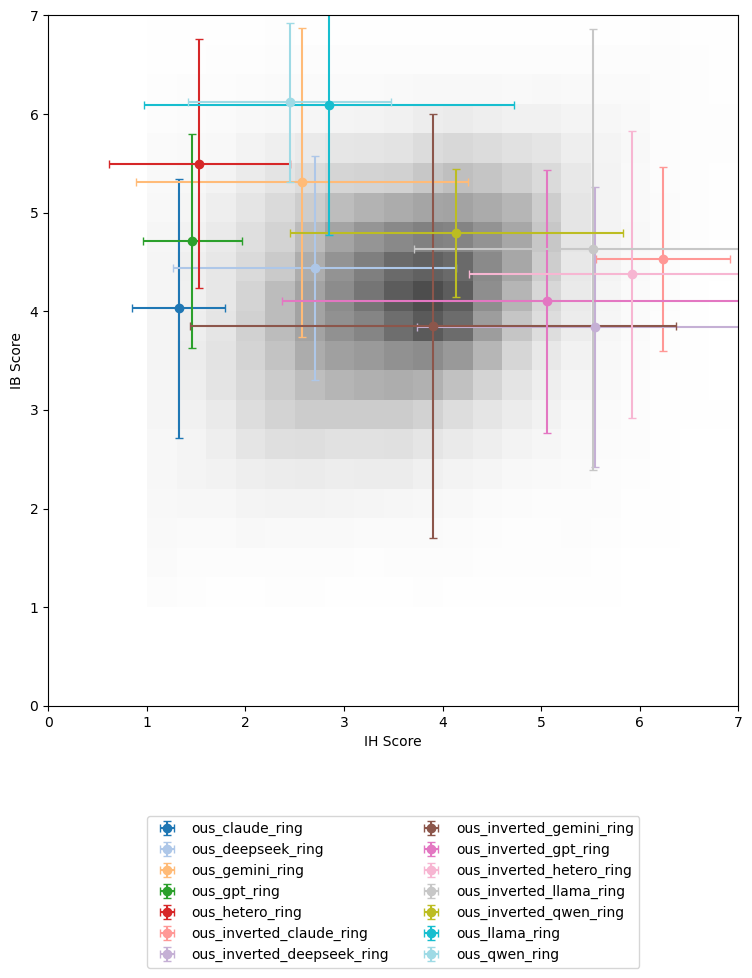

In [19]:
f = plot_IH_v_IB (ring_by_category, use_std = True)